<a href="https://colab.research.google.com/github/NicoBrandstetterr/location-of-the-sigma-spindles-in-EEG/blob/keim-job/location_sigma_spindles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nicolas Brandstetter
Felipe Keim

Predicción de inicio y final de un evento de huso del sueño

In [1]:
#Imports
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import os
import sys
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math 
from IPython.display import clear_output 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# loading data

In [3]:
!unzip "/content/drive/MyDrive/Cursos/Primavera 2022/Inteligencia/Proyecto/Data/Localización de husos sigma.zip" -d "/content/data"
clear_output() 
print('****Base de datos descomprimida****')

****Base de datos descomprimida****


In [4]:
test_marks    = np.load('data/Localización de husos sigma en el EEG del sueño/test_marks.npy')
test_signals  = np.load('data/Localización de husos sigma en el EEG del sueño/test_signals.npy')
train_marks   = np.load('data/Localización de husos sigma en el EEG del sueño/train_marks.npy')
train_signals = np.load('data/Localización de husos sigma en el EEG del sueño/train_signals.npy')
val_marks     = np.load('data/Localización de husos sigma en el EEG del sueño/val_marks.npy')
val_signals   = np.load('data/Localización de husos sigma en el EEG del sueño/val_signals.npy')

In [5]:
scaler = StandardScaler()
scaler = scaler.fit(np.concatenate((test_signals,train_signals,val_signals)))

val_signals_normalized = scaler.transform(val_signals)
test_signals_normalized = scaler.transform(test_signals)
train_signals_normalized = scaler.transform(train_signals)

In [6]:
val_marks = torch.tensor(val_marks)
test_marks = torch.tensor(test_marks)
train_marks = torch.tensor(train_marks)

val_signals = torch.tensor(val_signals_normalized)
test_signals = torch.tensor(test_signals_normalized)
train_signals = torch.tensor(train_signals_normalized)

## Creating Dataset

In [7]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)

# entrenamiento y visualización

## Curves

In [8]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()
    plt.show()


## IOU

In [9]:
SMOOTH = 1e-6

def iou_pytorch(y_predicted: torch.Tensor, y_vals: torch.Tensor,eva=False):

    largo=len(y_vals)
    error_array=np.zeros(largo)
    count=0
    for pred,y_val in zip(y_predicted,y_vals):
        pred=pred.squeeze(0)
        intervalo_inter = [max(pred[0],y_val[0]),min(pred[1],y_val[1])]
        rest = intervalo_inter[1] - intervalo_inter[0]
        inter = rest if rest>0 else 0

        len_predicted = pred[1] - pred[0]
        len_val = y_val[1] - y_val[0]
        union = len_predicted + len_val - inter
        error_array[count]=(inter/(union+1e-6))
        count+=1
        
    return torch.tensor(1-np.mean(error_array),requires_grad=True)

## Evaluation

In [36]:
def evaluate(val_loader, model, criterion, use_gpu,delta):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0
    y_predicted=[]
    error_list=[]
    delta=math.sqrt(delta)
    for x_val, y_val in val_loader:
        for x,y in zip(x_val,y_val):   
            x=x.unsqueeze(0)
            x=x.unsqueeze(0)
            if use_gpu:
                x = x.cuda()
                y = y.cuda()
            y_pred=model(x)
            y_pred=y_pred.reshape(2)

            err=criterion(y_pred.unsqueeze(0),y.unsqueeze(0)) ###,eva=True) 
            error_list.append(err)
            y_predicted.append(y_pred)
            cumulative_predictions += (err<delta)
            cumulative_loss += err
        data_count = x_val.shape[0]

    val_acc = cumulative_predictions / data_count  #data_count = len(y_val)
    val_loss = cumulative_loss/len(y_val)
    return val_acc, val_loss

## Training set up

### Train step 

In [44]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu,delta):
    # Predicción
    #y_predicted=[]
    #for pred in x_batch:
    #    pred=pred.unsqueeze(0)
    #    pred=pred.unsqueeze(0)
    #   y_predicted.append(model(pred))    ### NO ES NECESARIO, EL MODELO DEBERIA PROCESAR EL BATCH COMPLETO SI LAS DIMENSIONES CORRESPONDEN A COMO LO TOMA PYTORCH

    delta=math.sqrt(delta)
    y_predicted = model(x_batch.unsqueeze(1))     ### DIM (batch_size, channels, data_len)

    # Cálculo de loss
    loss = criterion(y_predicted.squeeze(), y_batch.float())   ### y_predicted e y_batch DEBEN TENER IGUAL DIM
    # Calculo de VP
    VP=int((loss<=delta))

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss, VP

### Train Model

In [50]:

def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
    delta=0.01
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # for i,x in enumerate(train_loader):
    #     a=[0,1,2,3,4]
    #     if i in a:
    #         print("loader: ",x[1])

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0


        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss,vp = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu,delta)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            #class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += vp

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / (train_acc_count/len(y_batch))   #multiplique por el batch size

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")
            iteration += 1


        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu,delta)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = 4*cumulative_train_corrects / train_acc_count   #multiplique por 4 por ahora

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    # if data_augmentation:
    #     train_dataset.dataset.transform = original_transform

    return curves

# Models Definition

## Conv1dModel

In [13]:

class CNN1d_Model(nn.Module):
    eva=False
    def __init__(
        self,
        dropout_p,
        input_size=1,
    ):
        
        super().__init__()
        self.conv_blocks = nn.Sequential(
            
            nn.Conv1d(input_size, 1, kernel_size=1, stride=1, padding="same"),

            nn.Conv1d(input_size, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,2,kernel_size=3, stride = 1, padding="same"),
            
        )

    def forward(self, x,evaa=False):
        return self.conv_blocks(x)

# Training

In [41]:
lr = 0.001
batch_size = 4
#criterion = iou_pytorch
criterion = torch.nn.MSELoss()
epochs = 50

Epoch 1/50
Iteration 186 - Batch 186/1116 - Train loss: 36676.614793094086, Train acc: 0.014705882352941176
Iteration 372 - Batch 372/1116 - Train loss: 24397.109201057985, Train acc: 0.024128686327077747
Iteration 558 - Batch 558/1116 - Train loss: 19650.471843030246, Train acc: 0.030858676207513418
Iteration 744 - Batch 744/1116 - Train loss: 17066.264376687683, Train acc: 0.03691275167785235
Iteration 930 - Batch 930/1116 - Train loss: 15026.846308756336, Train acc: 0.04806659505907626
Val loss: 4223.091796875, Val acc: 0.7306416034698486
Epoch 2/50
Iteration 1302 - Batch 186/1116 - Train loss: 5407.861778055283, Train acc: 0.1443850267379679
Iteration 1488 - Batch 372/1116 - Train loss: 5236.5955502916595, Train acc: 0.14209115281501342
Iteration 1674 - Batch 558/1116 - Train loss: 5080.218937691295, Train acc: 0.15026833631484796
Iteration 1860 - Batch 744/1116 - Train loss: 4810.218003486787, Train acc: 0.1587248322147651
Iteration 2046 - Batch 930/1116 - Train loss: 4569.2724483

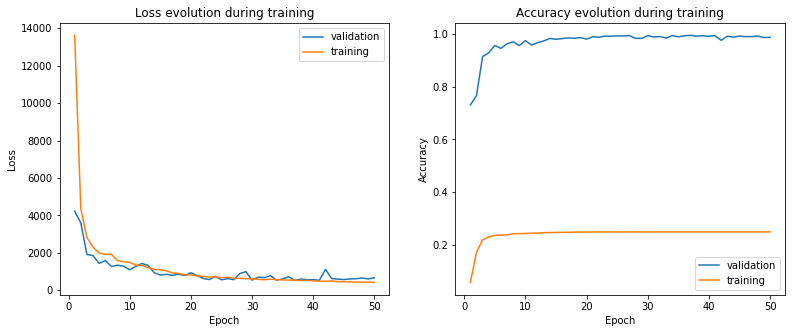

In [42]:
CNN1d = CNN1d_Model(dropout_p=0.5)
curves = train_model(
    CNN1d,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=False,
    data_augmentation=False,
    delta=5000*5000
)
show_curves(curves)

In [51]:
lr = 0.001
batch_size = 4
#criterion = iou_pytorch
criterion = torch.nn.MSELoss()
epochs = 40

Epoch 1/40
Iteration 186 - Batch 186/1116 - Train loss: 37367.62215517421, Train acc: 0.0
Iteration 372 - Batch 372/1116 - Train loss: 24603.418052366527, Train acc: 0.005361930294906166
Iteration 558 - Batch 558/1116 - Train loss: 20523.36796676281, Train acc: 0.0035778175313059034
Iteration 744 - Batch 744/1116 - Train loss: 18334.183732287514, Train acc: 0.004026845637583893
Iteration 930 - Batch 930/1116 - Train loss: 17293.334599774582, Train acc: 0.0053705692803437165
Val loss: 12267.2236328125, Val acc: 0.1393805295228958
Epoch 2/40
Iteration 1302 - Batch 186/1116 - Train loss: 12034.316481319978, Train acc: 0.0
Iteration 1488 - Batch 372/1116 - Train loss: 11981.491838634174, Train acc: 0.005361930294906166
Iteration 1674 - Batch 558/1116 - Train loss: 11747.299866050214, Train acc: 0.0035778175313059034
Iteration 1860 - Batch 744/1116 - Train loss: 11225.3950401767, Train acc: 0.0026845637583892616
Iteration 2046 - Batch 930/1116 - Train loss: 10508.875732487433, Train acc: 0.

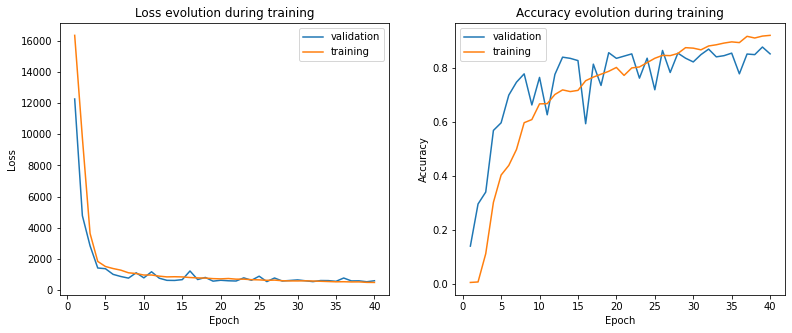

In [52]:
CNN1d = CNN1d_Model(dropout_p=0.5)
curves = train_model(
    CNN1d,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=False,
    data_augmentation=False,
    delta=1000*1000
)
show_curves(curves)